<h1 align='center'> Time Series Exploratory Data Analysis(EDA) </h1>

In this notebook, I will be showing some common but effective ways to explore the time series data. In the first section we will explore how can we use `pandas` and other libraries in python to deal with data time columns, and in later section we will try to summaries the data at hand using several modules and functions present in those tools.

We will be using following tools and tech stacks:

    - Python
    - Pandas
    - Numpy
    - Matplotlib
    - statsmodels

The only pre-requisit is having some introductory familiarity with `Python`.

Let's start!


## Contents:

* About Data
* Introduction to Time Series
* Dealing with datetime in Pandas
* Time Resampling
* Time upsampling
* Rolling window
* Expanding window


## About Data

We are using Superstore sales data that can be downloaded from <a href = 'https://community.tableau.com/docs/DOC-1236'>here</a>. This data has `21` columns and `9995` rows. 

The data shows sales of items of differrent categories from a supestore of USA for a certain period of time. 


## Introduction to time series

Time series can be think as an ordered sequence of values of a variable at equally spaced time intervals. 

Time series analysis involves studying **patterns**, **trends** and dependencies in the data points to make predictions, understand underlying processes and make informed decisions.




## Load the data

In [89]:
#imports
import pandas as pd
import numpy as np

In [90]:
sales = pd.read_excel("data/Superstore_Sales_Records.xls")


In [91]:
sales.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


## Basic EDA

Let's see how many rows and columns we have in the sales data.

In [92]:
print(f"Total number of rows : {sales.shape[0]}")
print(f"Total number of columns : {sales.shape[1]}")

Total number of rows : 9994
Total number of columns : 21


Check the data type of columns

In [93]:
sales.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In this analysis we are only concerned about sales columns and the dates of those transactions. So, the columns of interests are `OrderDate`, `Category` and `Sales`.

Here we want to analyze how the sales of a particular category varies with time. For example suppose in the data we have a category for furnitures and it might be possible people are more prone to buy furnitures in summer. We want to do these kind of analysis to gain more sight in sales and the we can take more mature decisions about buying buffer stocks or not doing so.



In [94]:
#select the relevant columns

sales = sales[['Order Date', 'Category', 'Sales']]


In [95]:
sales.head()

,Order Date,Category,Sales
0,2016-11-08,Furniture,261.9600
1,2016-11-08,Furniture,731.9400
2,2016-06-12,Office Supplies,14.6200
3,2015-10-11,Furniture,957.5775
4,2015-10-11,Office Supplies,22.3680


**Get an overall summary**

In [96]:
sales.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,9994.0,229.858001,623.245101,0.444,17.28,54.49,209.94,22638.48


In [97]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  9994 non-null   datetime64[ns]
 1   Category    9994 non-null   object        
 2   Sales       9994 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 234.4+ KB


We don't have any null values in these three tables so we don't need to deal with null values in preprocessing step before modeling.

**Check for distinct values**

In [98]:
sales.nunique()

Order Date    1237
Category         3
Sales         6144
dtype: int64

In the whole data set we have only three categories

**Display the categories and their frequencies**

In [99]:
sales['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

**Set Order Date as Index**

In [100]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'])

sales.set_index('Order Date', inplace=True)

sales.head()

,Category,Sales
Order Date,,
2016-11-08,Furniture,261.9600
2016-11-08,Furniture,731.9400
2016-06-12,Office Supplies,14.6200
2015-10-11,Furniture,957.5775
2015-10-11,Office Supplies,22.3680


**Range of Order Date**


In [101]:
max_date = sales.index.max()
min_date = sales.index.min()

print(f"Maximum order date is {max_date}")
print(f"Minimum order date is {min_date}")
print(f"Total time span is around {(max_date.year - min_date.year)} years")

Maximum order date is 2017-12-30 00:00:00
Minimum order date is 2014-01-03 00:00:00
Total time span is around 3 years


## Time resampling

Resampling is the for frequency conversion and resampling of time series. So if you need to change the data from daily frequency to monthly or yearly we can resample the data accordingly. 

In `pandas` we have resampling functionm `resample()`. When calling `.resample()` we need to pass in a rule parameter, then we need to call some aggregate functions.

The **rule** parameter describes the frequency with which to apply the agg function(daily, monthly yearly etc).

**Note** that we need to apply some aggregate function after resampling because after resampling we need to join the rows (mean, sum, count etc.)

**Example:**

In [102]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
sales = pd.read_excel("data/Superstore_Sales_Records.xls")

### Downsampling

In [104]:
#filter out for furniture category
sales_sample = sales[sales['Category']=='Furniture']

sales_sample.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


For same date we have multiple sales values. We need to do group by over `Order Date` so that we can have one to one mapping.

In [105]:
sales_sample = sales_sample.reset_index().groupby(by=['Order Date']).agg({'Sales':sum})

#order by Order Date
sales_sample.sort_index(inplace=True)

In [106]:
sales_sample.head(5)

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


Above data does not seem to have daily or weekly records. There seems some discontinuties. 

We can use resampling technique to make it on monthly level like start date of each month.

In [107]:
sales_sample_monthly = sales_sample.resample(rule = 'MS').mean() # MS - Month Start is rule

sales_sample_monthly.head()

,Sales
Order Date,
2014-01-01,480.194231
2014-02-01,367.931600
2014-03-01,857.291529
2014-04-01,567.488357
2014-05-01,432.049188


Now this seems nice! You have sales values for start of each month between given data range in the data.


#### Plot

Let's visualize raw data and data after resampling over `MS` frequency.


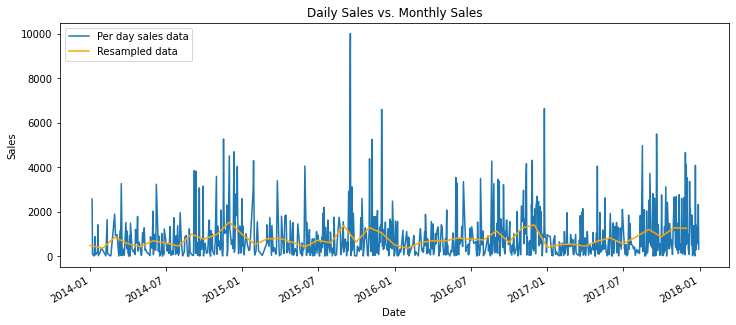

In [108]:
fig, ax = plt.subplots(figsize=(12, 5))
# Plot the raw data
sales_sample['Sales'].plot(ax=ax, label='Per day sales data')

# Plot the resampled data 
sales_sample_monthly['Sales'].plot(ax=ax, label='Resampled data', color='orange')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Daily Sales vs. Monthly Sales')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

Resampled data seems to have some nice pattern wrt the raw sales data.

In Pandas, we have many inbuilt rules like I used `MS` rule in above cell. We can also make it on yealy level or even daily level using inbuilt rules. For aggregate functions(min/max/sum etc) we can also define custom aggregators by our own.

Let's see a custom rule below.

In [109]:
def first_day(entry):
    """
        Returns the first isnatnce of the period, regardless of sampling rate
    """
    if(len(entry)):

        return entry[0]

In [110]:
sales_sample.resample(rule = 'A').apply(first_day)

,Sales
Order Date,
2014-12-31,2573.82
2015-12-31,452.45
2016-12-31,173.94
2017-12-31,975.49


### Time upsampling

In this we resample to shorter time frame, for example monthly data to weekly/biweekly/daily etc. Because of this, many bins are created with `NaN` values and to fill these there are different methods that can be used as pad method and bfill method. 

Let's try to upsample monthly sales data to weekly and then visualize the resulatnt plot.

In [111]:
sales_sample_monthly = sales_sample.resample(rule = 'MS').mean() # MS - Month Start is rule

sales_sample_weekly = sales_sample_monthly.resample('W').bfill()

sales_sample_weekly.head()

,Sales
Order Date,
2014-01-05,367.931600
2014-01-12,367.931600
2014-01-19,367.931600
2014-01-26,367.931600
2014-02-02,857.291529


Data is now on weekly level. Let's plot the downsampled and upsampled data in same view.

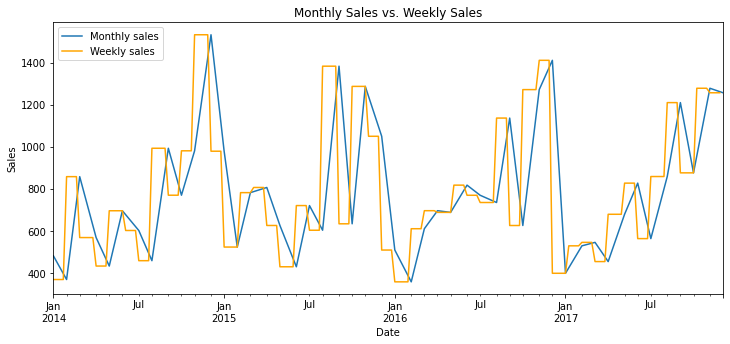

In [112]:
fig, ax = plt.subplots(figsize=(12, 5))
# Plot the down sampled
sales_sample_monthly['Sales'].plot(ax=ax, label='Monthly sales')

# Plot the upsampled data 
sales_sample_weekly['Sales'].plot(ax=ax, label='Weekly sales', color='orange')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales vs. Weekly Sales')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

## Time Shifting

Sometimes we may need to shift all the data up or down along the time series index. We can use pandas in built method `shift()` to accomplished that.

**Example:**

In [113]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### shift forward

This methods shifts the entire data index a given number of rows, without regard for time periods (months & years). It returns a modified copy of the original DataFrame.

In [114]:
sales = pd.read_excel("data/Superstore_Sales_Records.xls")

sales_furniture = sales[sales['Category']=='Furniture']

#sort the values and group by over 
sales_furniture = sales_furniture.groupby(by='Order Date').agg({'Sales':sum})
sales_furniture.sort_index(inplace=True)

sales_furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [115]:
#resample it on monthly level
sales_furniture = sales_furniture.resample('MS').mean()
sales_furniture.head()

,Sales
Order Date,
2014-01-01,480.194231
2014-02-01,367.931600
2014-03-01,857.291529
2014-04-01,567.488357
2014-05-01,432.049188


In [116]:
#shit the time by perioid 1

sales_furniture['lag_1'] = sales_furniture.shift(periods=1)
sales_furniture.head()

,Sales,lag_1
Order Date,,
2014-01-01,480.194231,NaN
2014-02-01,367.931600,480.194231
2014-03-01,857.291529,367.931600
2014-04-01,567.488357,857.291529
2014-05-01,432.049188,567.488357


If you compare the above two tables you obeserve that we shifted the `Sales` values in forward fashion so after shifting the first entry got `nan` value.

**Plot**

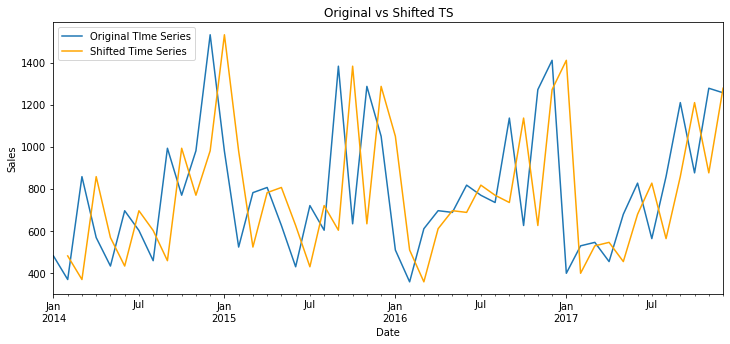

In [117]:
fig, ax = plt.subplots(figsize=(12, 5))
# Plot orig ts
sales_furniture['Sales'].plot(ax=ax, label='Original TIme Series')

# Plot the shifted ts
sales_furniture['lag_1'].plot(ax=ax, label='Shifted Time Series', color='orange')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Original vs Shifted TS')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

#### Shift backward


In [118]:
sales_sample.tail()

,Sales
Order Date,
2017-12-24,1393.4940
2017-12-25,832.4540
2017-12-28,551.2568
2017-12-29,2330.7180
2017-12-30,323.1360


In [119]:
sales_sample.shift(periods=-1).tail()

,Sales
Order Date,
2017-12-24,832.4540
2017-12-25,551.2568
2017-12-28,2330.7180
2017-12-29,323.1360
2017-12-30,NaN


This also works as shift forward but just in opposite direction.

**Note** that the shift also takes a parameter `freq` and when it is not passed, it shift the index without realigning the data. If freq is passed the index will be increased using the periods the freq.

## Rolling window mean

The rolling average or moving average is simple mean of of last `n` values. It can help us in finding trends that would be otherwise hard to detect.

    df.rolling(n).mean(n)  where n - window size

The main idea is to divide the data into windows to time, and then calculate an aggregate function for each window. In this way we obtain a simple moving avearge.

Let's look at sales data of furniture and try to calculate the rolling mean for it.

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sales_data = pd.read_excel('data/Superstore_Sales_Records.xls', index_col='Order Date', parse_dates=True)

In [121]:
sales_data.columns

Index(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [122]:
sales_furniture = sales_data.query("Category=='Furniture'", )

sales_furniture.head(5)

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2016-11-08,2,CA-2016-152156,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2015-10-11,4,US-2015-108966,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
2014-06-09,6,CA-2014-115812,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
2014-06-09,11,CA-2014-115812,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


Sort the data over Order Date and filter out all the extra columns other than `Sales` column.

In [123]:
#sort the data over Order Date
sales_furniture = sales_furniture.sort_index()
sales_furniture = sales_furniture[['Sales']]

sales_furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


In [124]:
#aggregate values over Order Date
sales_furniture = sales_furniture.groupby(by='Order Date').agg({'Sales':sum})

In [125]:
sales_furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


Plot the above sales data per Order Date

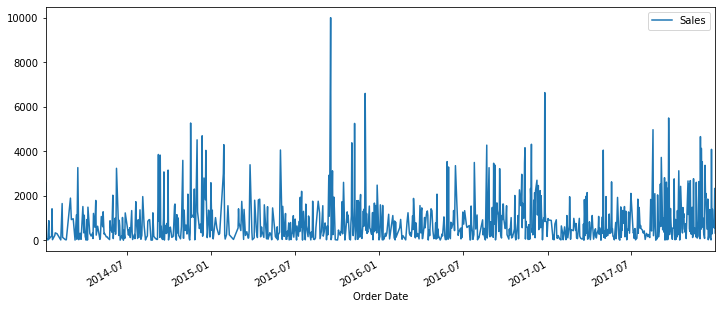

In [126]:
sales_furniture.plot(figsize=(12, 5)).autoscale(axis='x', tight=True)

This seems messy. Let's try to resample data over monthly basis and then try to visualize the graph.

In [127]:
sales_furniture = sales_furniture.resample('MS').agg(sum)

sales_furniture.head()

,Sales
Order Date,
2014-01-01,6242.525
2014-02-01,1839.658
2014-03-01,14573.956
2014-04-01,7944.837
2014-05-01,6912.787


We can also do resampling on Weekly level and try to visualize the resultant data but for time being I am doing on Monthly level.

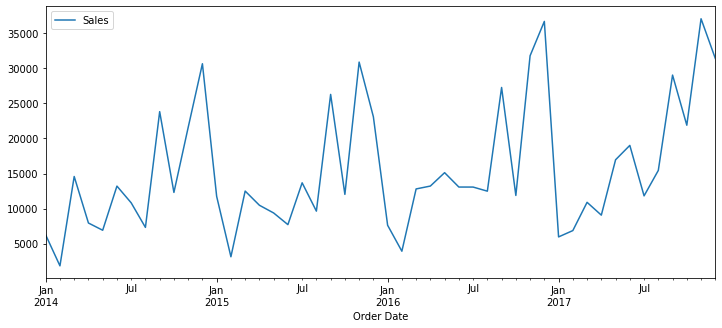

In [128]:
sales_furniture.plot(figsize=(12, 5)).autoscale(axis='x', tight=True)

Now this seems to  have some pattern. Here we have plotted the Sales of Furnitures on monthly frequency like for at start of each month what is the Sales.

Now let's see the rolling mean of Sales data and I will be ploitting the data in the same view since it will be much easier to visualiza and compare. I will be taking the window size as `3` which basically is per quarter.

In [129]:
sales_furniture['Quaterly rolling mean'] = sales_furniture['Sales'].rolling(window=3).mean()

sales_furniture.head()

,Sales,Quaterly rolling mean
Order Date,,
2014-01-01,6242.525,NaN
2014-02-01,1839.658,NaN
2014-03-01,14573.956,7552.046333
2014-04-01,7944.837,8119.483667
2014-05-01,6912.787,9810.526667


In above step we got some `NaN` values and it will be always the case in calculating rolling window aggregation. If we choose the window size as `n` the first `n-1` values will be `NaN`.

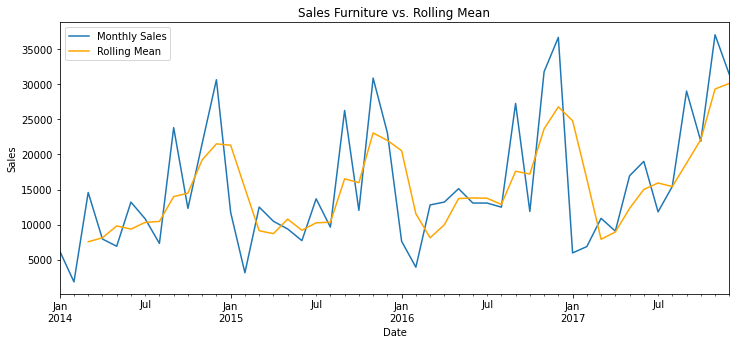

In [130]:
fig, ax = plt.subplots(figsize=(12, 5))
# Plot the sales_furniture data
sales_furniture['Sales'].plot(ax=ax, label='Monthly Sales')

# Plot the sales_furniture_rolling data
sales_furniture['Quaterly rolling mean'].plot(ax=ax, label='Rolling Mean', color='orange')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales Furniture vs. Rolling Mean')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()

Rolling mean seems more stable here.

## Expanding window

Expanding window, also known as a cumulative moving window, is a concept used in time series analysis to calculate various statistics over a growing portion of the data as the window expands. 

**This can be particularly useful for understanding trends and patterns in a time series over time.**

*Plot the cumulative average sales of each quater.*

In [131]:
sales_furniture['Exapanding mean'] = sales_furniture['Sales'].expanding(min_periods=3).mean()


### Plot

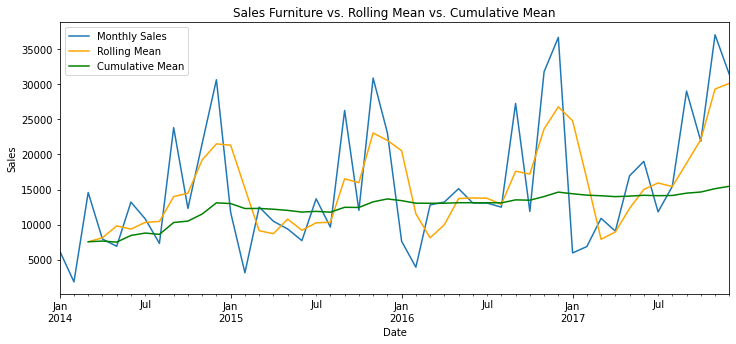

In [132]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the sales_furniture data
sales_furniture['Sales'].plot(ax=ax, label='Monthly Sales')

# Plot the sales_furniture rolling mean
sales_furniture['Quaterly rolling mean'].plot(ax=ax, label='Rolling Mean', color='orange')

# Plot the sales_furniture cumulative mean
sales_furniture['Exapanding mean'].plot(ax=ax, label='Cumulative Mean', color='green')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales Furniture vs. Rolling Mean vs. Cumulative Mean')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()


Cumulative means seems somewhat stationary over time. 